# Standardized Groundwater Index (SGI)
*R.A. Collenteur, University of Graz, November 2020*

To study the occurrence of groundwater droughts [Bloomfield and Marchant (2013)](#References) developed the Standardized Groundwater Index (SGI). More and more SGI values are being used to study and quantify groundwater droughts. In this Notebook it is shown how to compute the SGI using Pastas, and how Pastas models may be used to obtain groundwater level time series with regular time steps. The SGI implemented in Pastas (`ps.stats.sgi`) is based on the description in [Bloomfield and Marchant (2013)](#References).

The SGI requires regular time steps between groundwater levels observation, while historic groundwater level time series are often characterized by irregular time intervals between observations. To overcome this issue, [Marchant  and Bloomfield(2018)](#References) applied time series models using impulse response functions to simulate groundwater level time series at a regular time interval. Here, this methodology is extended by using evaporation and precipitation as model input and using a nonlinear recharge model ([Collenteur et al. (2021)](#References)) to compute groundwater recharge and finally groundwater levels.

**Note that this notebook is meant as an example of how Pastas models may be used to support studies computing SGI values, and not as an guide how to compute or interpret the SGI values.**

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:09:13) [Clang 13.0.1 ]
NumPy version: 1.22.3
SciPy version: 1.9.3
Pandas version: 1.5.1
Pastas version: 0.23.0b
Matplotlib version: 3.6.2


## The first example model

### 1. Loading the data
In this example we model the groundwater levels for a monitoring well (B32C0639, filter 1) near the town "de Bilt" in the Netherlands. Precipitation and evaporation are available from the nearby meteorological station of the KNMI. The groundwater level observations have irregular time steps.

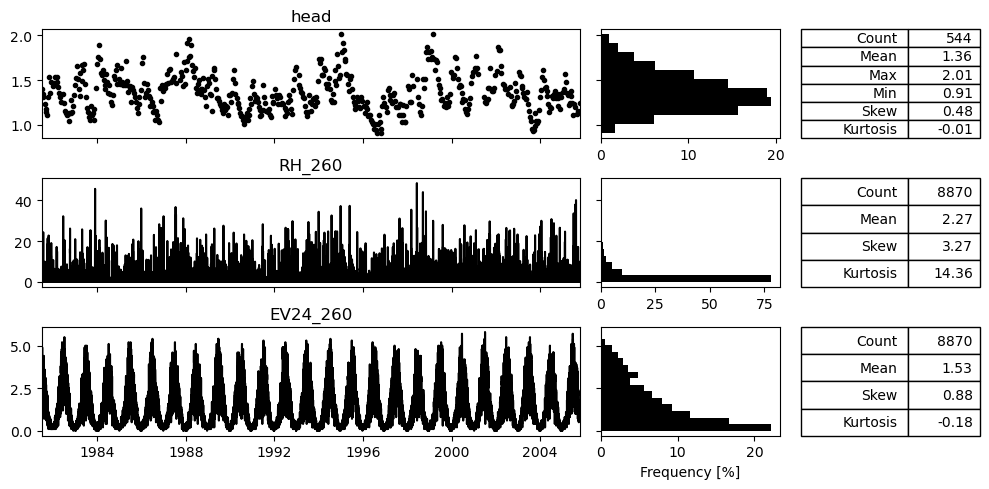

In [2]:
# Load input data
head = pd.read_csv(
    "data/B32C0639001.csv", parse_dates=["date"], index_col="date"
).squeeze()
evap = pd.read_csv("data/evap_260.csv", index_col=0, parse_dates=[0]).squeeze()
rain = pd.read_csv("data/rain_260.csv", index_col=0, parse_dates=[0]).squeeze()

# Plot input data
ps.plots.series(head, [rain, evap]);

### 2. Creating and calibrating the model
We now create a simple time series model using a parsimonious non-linear recharge model to translate precipitation and evaporation into groundwater recharge. The recharge flux is then convoluted with an exponential response function to compute the contribution of the recharge to the groundwater level fluctuations. The results are plotted below.

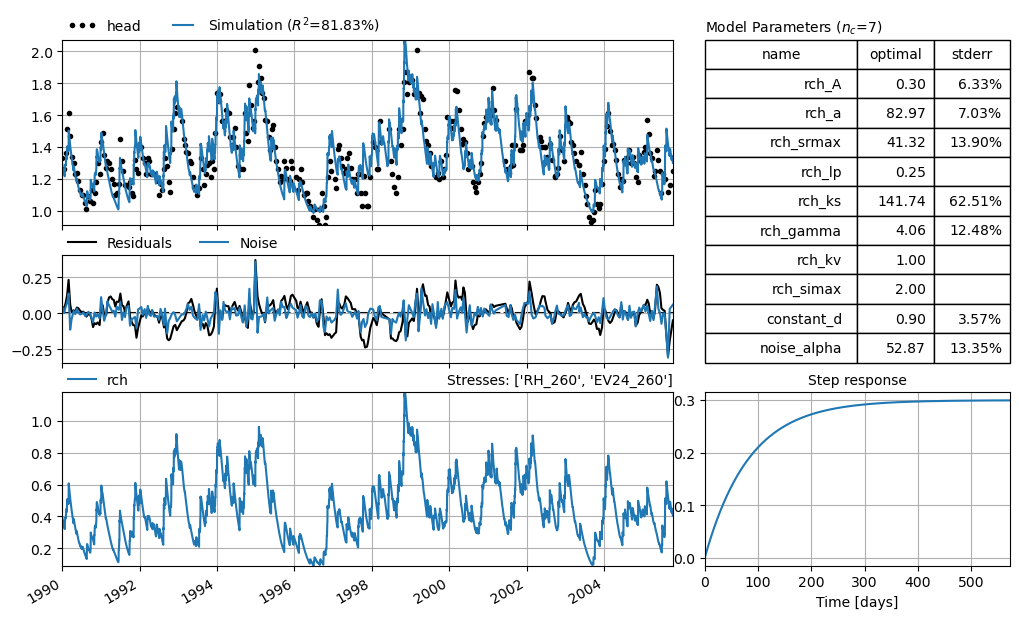

In [3]:
# Create the basic Pastas model
ml = ps.Model(head)

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential, name="rch")
ml.add_stressmodel(rm)

# Solve the model
ml.solve(noise=True, tmin="1990", report=False)
ml.plots.results(figsize=(10, 6));

### 3. Computing and visualizing the SGI
The plot above shows that we have a pretty good model fit with the data. This is particularly important when we want to compute the SGI using the simulated time series. We now compute the SGI and show the models results and estimated SGI in one figure. A possible extension to the SGI computation below is to take the uncertainty of the groundwater level simulation into account, as is done by [Marchant and Bloomfield (2018)](#References).

Text(0.5, 1.0, 'Standardized Groundwater Index')

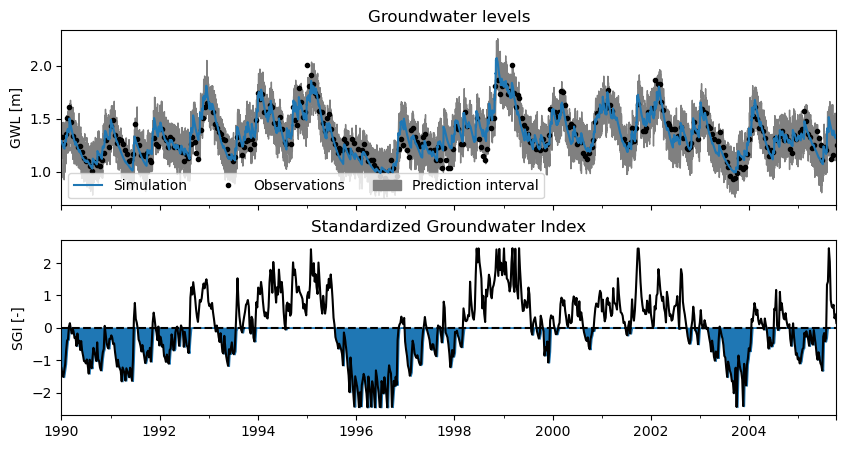

In [4]:
# Compute the SGI
sim = ml.simulate(tmin="1990")
sgi = ps.stats.sgi(sim.resample("W").mean())
ci = ml.fit.prediction_interval(n=10)

# Make the plot
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Upper subplot
sim.plot(ax=ax1, zorder=10)
ml.oseries.series.plot(ax=ax1, linestyle=" ", marker=".", color="k")
ax1.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="gray")
ax1.legend(["Simulation", "Observations", "Prediction interval"], ncol=3)

# Lower subplot
sgi.plot(ax=ax2, color="k")
ax2.axhline(0, linestyle="--", color="k")
droughts = sgi.to_numpy(copy=True)
droughts[droughts > 0] = 0
ax2.fill_between(sgi.index, 0, droughts, color="C0")

# Dress up the plot
ax1.set_ylabel("GWL [m]")
ax1.set_title("Groundwater levels")
ax2.set_ylabel("SGI [-]")
ax2.set_title("Standardized Groundwater Index")

## Second Example: data with trends
For the example above precipitation and evaporation were sufficient to  accurately simulate the groundwater levels. Now we look at an example of where this is not the case. The groundwater levels are again observed near the town of de Bilt in the Netherlands. The time series have a more irregularities in the time step between observations and end with high frequency observations.

### 1. Create a simple model

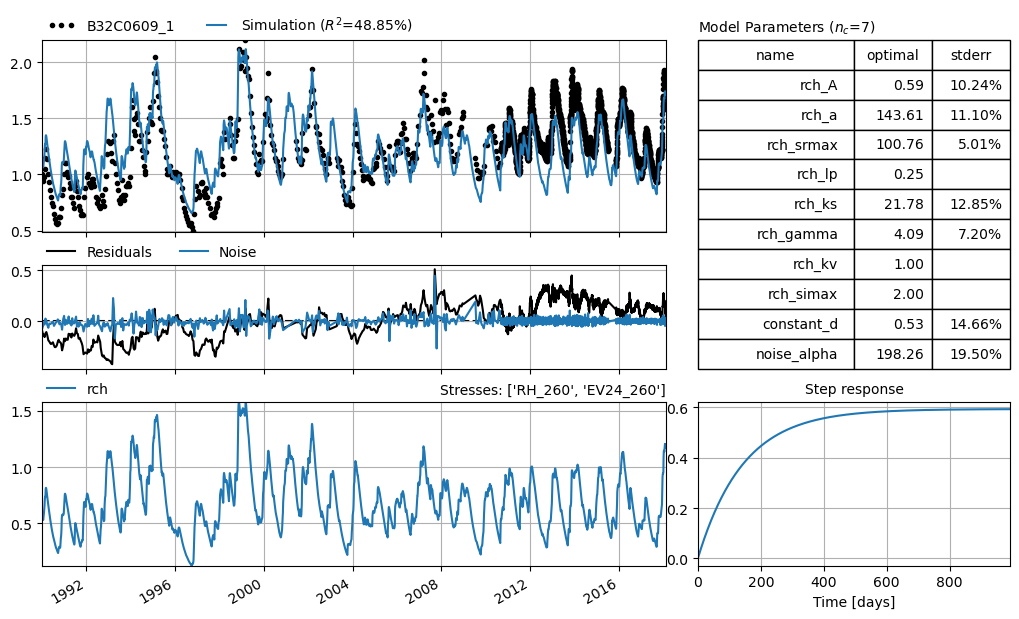

In [5]:
# Loads heads and create Pastas model
head2 = pd.read_csv("data/B32C0609001.csv", parse_dates=[0], index_col=0).squeeze().dropna()
ml2 = ps.Model(head2)

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential, name="rch")
ml2.add_stressmodel(rm)

# Solve and plot the model
ml2.solve(noise=True, tmin="1990", report=False)
ml2.plots.results(figsize=(10, 6));

### 2. Add linear trend
Clearly the model fit with the data in the above figure is not so good. Looking at the model residuals (simulation - observation) we can observe a steady upward trend in the residuals. Let's try and add a linear trend to the model to improve the groundwater level simulation.

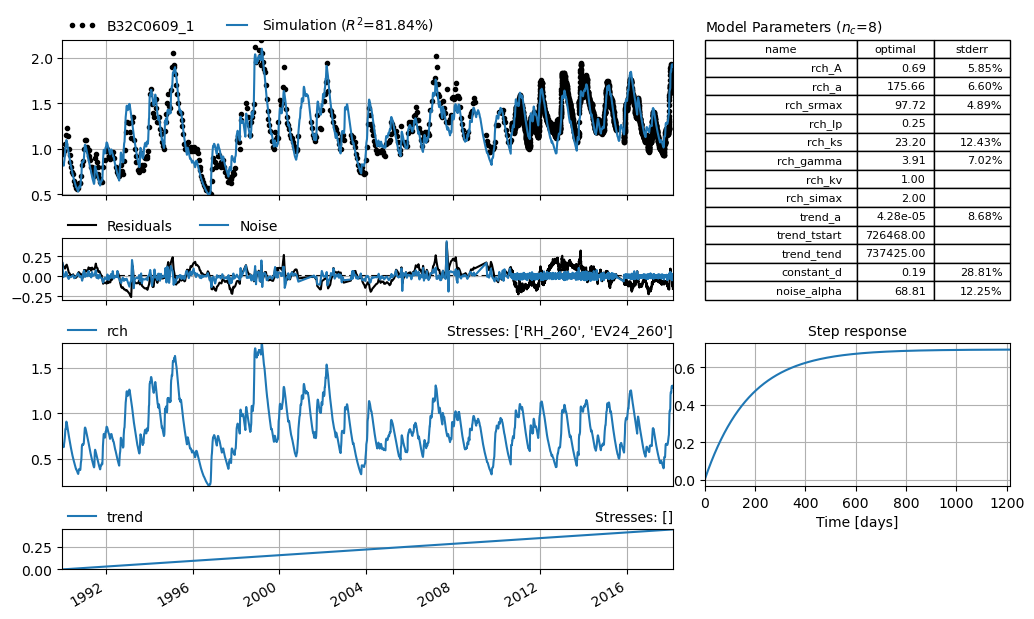

In [6]:
# Add a linear trend
tm = ps.LinearTrend("1990", "2020", name="trend")
ml2.add_stressmodel(tm)

# Solve the model
# ml2.solve(noise=False, tmin="1990", report=False)  # Get better initial estimated first
ml2.solve(noise=True, tmin="1990", report=False)
ml2.plots.results(figsize=(10, 6));

### 3. Computing and plotting the SGI
The model fit for the model above looks a lot better. Now we can compute and plot the SGI again as we did before.

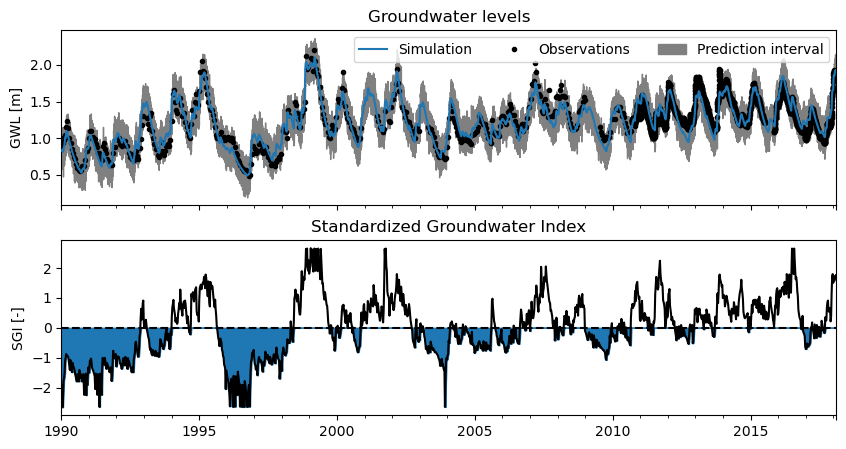

In [7]:
# Compute the SGI
sim = ml2.simulate(tmin="1990")
sgi = ps.stats.sgi(sim.resample("W").mean())
ci = ml2.fit.prediction_interval(n=10)

# Make the plot
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Upper subplot
sim.plot(ax=ax1, zorder=10)
ml2.oseries.series.plot(ax=ax1, linestyle=" ", marker=".", color="k")
ax1.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="gray")
ax1.legend(["Simulation", "Observations", "Prediction interval"], ncol=3)

# Lower subplot
sgi.plot(ax=ax2, color="k")
ax2.axhline(0, linestyle="--", color="k")
droughts = sgi.to_numpy(copy=True)
droughts[droughts > 0] = 0
ax2.fill_between(sgi.index, 0, droughts, color="C0")

# Dress up the plot
ax1.set_ylabel("GWL [m]")
ax1.set_title("Groundwater levels")
ax2.set_ylabel("SGI [-]")
ax2.set_title("Standardized Groundwater Index");

## What about human influenced groundwater systems?
Let's explore the possibilities of using the Pastas framework a bit here. The first example showed SGI values for a system under natural conditions, with only recharge being enough to explain the groundwater level fluctuations. In the second example a small linear trend had to be added, without explicit knowledge of what may have caused this trend. In this third and final example we consider an aquifer system that is influenced by groundwater pumping. 

The question we want to answer is how the SGI values may have looked without groundwater pumping (a natural system) and compare these to the SGI values with groundwater pumping. We can see clearly from the model that groundwater pumping decreased the groundwater levels, but how does it impact the SGI values?

In [8]:
# Load input data
head = pd.read_csv("data_notebook_9/head.csv", parse_dates=True, index_col=0).squeeze()
prec = pd.read_csv("data_notebook_9/prec.csv", parse_dates=True, index_col=0).squeeze()
evap = pd.read_csv("data_notebook_9/evap.csv", parse_dates=True, index_col=0).squeeze()
well = pd.read_csv("data_notebook_9/well.csv", parse_dates=True, index_col=0).squeeze()

ps.validate_stress(well)

ERROR: The frequency of the index of time series well could not be inferred. Please provide a time series with a regular time step.


Note that the well data is not equidistant. For this example, we apply a backfill after resampling the time series to daily values.

In [9]:
well = well.asfreq("D").bfill()

Now we are ready to built the model.

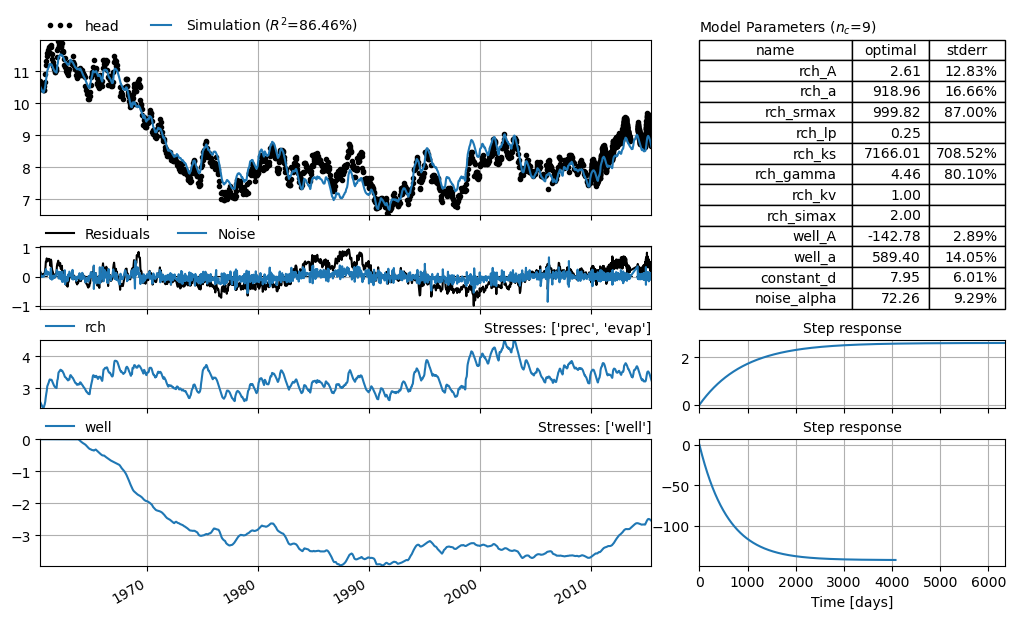

In [10]:
# Create the Pastas model
ml3 = ps.Model(head, name="heads")

# Add recharge and a well
sm = ps.RechargeModel(
    prec, evap, ps.Exponential, name="rch", recharge=ps.rch.FlexModel()
)
wm = ps.StressModel(well, ps.Exponential, well.name, up=False, settings="well")
ml3.add_stressmodel([sm, wm])

# Solve the model
ml3.solve(noise=True, report=False)
ml3.plots.results(figsize=(10, 6));

### 2. SGI with and without groundwater pumping
Now that we have a model with a reasonably good fit, we can use the model to separate the effect of groundwater pumping from the effect of recharge. We then compute SGI values on the groundwater levels with and without pumping and compare them visually. The results are shown below, and show very different SGI values as expected.

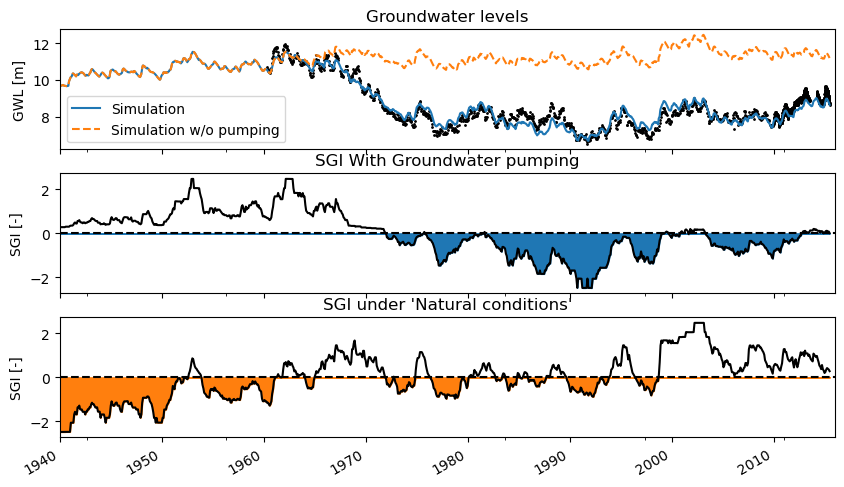

In [11]:
# Compute the SGI
sim = ml3.simulate(tmin="1940")
sgi = ps.stats.sgi(sim.resample("M").mean())
recharge = ml3.get_contribution("rch", tmin="1940")
sgi2 = ps.stats.sgi(recharge.resample("M").mean())
# ci = ml3.fit.prediction_interval()

# Make the plot
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

sim.plot(ax=ax1, x_compat=True)
(recharge + ml3.get_parameters("constant")).plot(ax=ax1, linestyle="--")
ml3.oseries.series.plot(
    ax=ax1, linestyle=" ", marker=".", zorder=-1, markersize=2, color="k", x_compat=True
)
# ax1.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="gray")
ax1.legend(["Simulation", "Simulation w/o pumping"], ncol=1)

sgi.plot(ax=ax2, color="k", x_compat=True)
ax2.axhline(0, linestyle="--", color="k")
droughts = sgi.to_numpy(copy=True)
droughts[droughts > 0] = 0
ax2.fill_between(sgi.index, 0, droughts, color="C0")

sgi2.plot(ax=ax3, color="k", x_compat=True)
ax3.axhline(0, linestyle="--", color="k")
droughts = sgi2.to_numpy(copy=True)
droughts[droughts > 0] = 0
ax3.fill_between(sgi2.index, 0, droughts, color="C1")

ax1.set_ylabel("GWL [m]")
ax1.set_title("Groundwater levels")
ax2.set_ylabel("SGI [-]")
ax2.set_title("SGI With Groundwater pumping")
ax3.set_ylabel("SGI [-]")
ax3.set_title("SGI under 'Natural conditions'")
plt.xlim("1940", "2016");

## References

- Bloomfield, J. P. and Marchant, B. P.: [Analysis of groundwater drought building on the standardised precipitation index approach](https://hess.copernicus.org/articles/17/4769/2013/), Hydrol. Earth Syst. Sci., 17, 4769–4787, 2013.
- Marchant, B. and Bloomfield, J.: [Spatio-temporal modelling of the status of groundwater droughts](https://doi.org/10.1016/j.jhydrol.2018.07.009), J. Hydrol., 564, 397–413, 2018
- Collenteur, R., Bakker, M., Klammler, G., and Birk, S. (2021) [Estimation of groundwater recharge from groundwater levels using nonlinear transfer function noise models and comparison to lysimeter data](https://doi.org/10.5194/hess-2020-392), Hydrol. Earth Syst. Sci., 25, 2931–2949.

## Data Sources

- The precipitation and evaporation time series are taken from the Dutch KNMI, meteorological station "de Bilt" (www.knmi.nl).
- The groundwater level time series were downloaded from Dinoloket (www.dinoloket.nl).